# MOPS for KBmod

Based off the CNN developed for the first ML search of the New Horizons 2020 search


In [1]:
import os, glob, sys
import time

import random
"""Import the basics: numpy, pandas, matplotlib, etc."""
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyl
import matplotlib.gridspec as gridspec
import pickle
"""Import keras and other ML tools"""
import tensorflow as tf
import keras

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv3D, Conv2D, MaxPool3D, MaxPool2D
from keras.layers.core import Dropout, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
"""Import scikit learn tools"""
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
"""Import astropy libraries"""
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy.visualization import interval

from trippy import tzscale
from trippy.trippy_utils import expand2d, downSample2d

from convenience_utils import calc_ecliptic_angle

from utils import shuffle

from ensemble_resnet import resnet_model

In [2]:

image_data_type = 'float32'

batch_size = 4096 
dropout_rate = 0.2
test_fraction = 0.05
select_bad_at_random = True
badGoodRatio = 1.5 #1.6 seems max
bad_edge_enhancement = 0.002

number_models = 3

useMedForNans = False #otherwise zero is used
useZscale = False


shuffle_augment = True # shuffle bootstrapping augmentation
double_flip = True # mirror vertically and horizontally augmentation
add_noise = False
rotate_augment = True
noise_level=3.0


#good ranges [19,21.5], [21, 23.5] [23.5,25.5], [25.5, 26.8]
nukeBright = 10.0 # if set to a real value, all fainter planted source associations will be set to false
nukeFaint = 27.0 # if set to a real value, all fainter planted source associations will be set to false
dist_lim = 4.0 #association to planted source
save_model_iteration = False

useSampleWeights = True

useTripletGrids = True



"""These are some of the flags."""
visits = ['03072', '03093']

chips = []
#for i in range(103,-1,-1):
for i in range(104):
    if i==9: continue
    if i in [89]: continue
    chips.append(str(i).zfill(3))
#chips = ['031','050']
    


# Data Exploration

First read in the data, and make it look like the data from the tutorial



In [3]:

# load the data
#sns_frames = []
n_edge_added = 0
n_bad_total = 0

reference_fits_images = []
ecl_angles = []
stamp_files = []
kb_xys,fs = [],[]
for i, c in enumerate(chips):
    for j, v in enumerate(visits):
        warps_path = f'/media/fraserw/SecondStage/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/HSC-R2/warps'
        reference_fits_images.append(glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')[0])
        ecl_ang = calc_ecliptic_angle(reference_fits_images[-1])
        ecl_angles.append(ecl_ang)
        if c=='050':
            ref_ecl_ang = ecl_ang
            print(ref_ecl_ang)
ecl_angles = np.array(ecl_angles)
rots = (ref_ecl_ang-ecl_angles)*180./np.pi
print(len(rots))
corners = np.array([-270., -180., -90., 0., 90., 180., 270.])
for i,r in enumerate(rots):
    rot = corners[np.argmin(np.abs(r-corners))]
    if rot<0: 
        rot+=360.
    print(chips[i%len(chips)],r,rot)
    rots[i] = rot/90.
rots = rots.astype(np.int)


1.4412754795592164
1.4418513917027855
204
000 -1.1550906834792976 0.0
001 -1.1873518094705156 0.0
002 -0.061540984348613076 0.0
003 -0.0983170107051293 0.0
004 0.9074954171103452 0.0
005 0.8732897447223871 0.0
006 1.8550824182546886 0.0
007 1.8149020476100624 0.0
008 -2.108994707975786 0.0
010 -2.128106320589695 0.0
011 -0.995145105377695 0.0
012 -1.0330049643741732 0.0
013 -0.13699027993142915 0.0
014 -0.16468738397494367 0.0
015 0.7059106927703981 0.0
016 0.6656933616781258 0.0
017 1.3977769616372469 0.0
018 1.362004999304686 0.0
019 -1.7191275654667364 0.0
020 -1.7540284872212881 0.0
021 -0.780284731963433 0.0
022 -0.812419793655703 0.0
023 -0.14731260989769324 0.0
024 -0.18529351865103108 0.0
025 0.4526086987577411 0.0
026 0.4215696466448263 0.0
027 1.0895931458549093 0.0
028 1.0580325195978442 0.0
029 1.6524018666447677 0.0
030 1.6075196750457097 0.0
031 178.60380287334638 180.0
032 178.5772997679311 180.0
033 179.3212996915617 180.0
034 179.2862520779912 180.0
035 179.86651517252

In [4]:
gridType = ''
if useTripletGrids:
    gridType = '_tg'
    
counter = 0
for i, c in enumerate(chips):
    for j, v in enumerate(visits):
        stamps_path = f'/media/fraserw/rocketdata/Projects/kbmod/stamps/{v}'
        warps_path = f'/media/fraserw/SecondStage/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/HSC-R2/warps'
        reference_fits_images.append(glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')[0])

        stamp_files.append(f'{stamps_path}/stamps{gridType}_{c}_w.pickle')

        
        ### get the image header and setup a WCS
        with fits.open(reference_fits_images[-1]) as han:
            header = han[1].header
            (A,B) = han[1].data.shape
            
        im_wcs = wcs.WCS(header)

        
        ### load the kbmod results
        kb_xy = []
        if os.path.isfile(f'/media/fraserw/rocketdata/Projects/kbmod/kbmod_results/{v}/results_{c}_upper_0/results_MERGED.txt'):
            #check if the kbmod results from CANFAR are available
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/kbmod_results/{v}/results_{c}_upper_0/results_MERGED.txt') as han:
                data = han.readlines()
        else:
            ### otherwise open a local copy
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/kbmod_results/{v}/results_{c}_lower/results_LOWER.txt') as han:
                data = han.readlines()
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/kbmod_results/{v}/results_{c}_upper/results_UPPER.txt') as han:
                data += han.readlines()

        for ii in range(len(data)):
            s = data[ii].split()
            x, y = float(s[5]), float(s[7])
            repeat = False
            for jj in range(len(kb_xy)):
                if kb_xy[jj][0]==x and kb_xy[jj][1]==y:
                    repeat = True
                    break
            if not repeat:
                kb_xy.append([float(s[5]) , float(s[7]) , float(s[9]), float(s[11]), float(s[1]), 0.0])
        kb_xy = np.array(kb_xy)
        
        ### load the plantlist sources
        p_xy = []
        if v == '03072':
            with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_May25-lsst/rerun/processCcdOutputs/{v}/HSC-R2/corr/planted/CORR-0218606-{c}.plantList') as han:
                data = han.readlines()
        elif v == '03093':
            with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_June19-lsst/rerun/processCcdOutputs/{v}/HSC-R2/corr/planted/CORR-0220262-{c}.plantList') as han:
                data = han.readlines()
                
        for ii in range(1,len(data)):
            s = data[ii].split()
            ra,dec = float(s[1]), float(s[2])
            coord = np.array(im_wcs.all_world2pix(ra, dec, 0))

            x,y = coord[0],coord[1]
            #x = float(s[3]) + offsets[c][0]
            #y = float(s[4]) + offsets[c][1]
            repeat = False
            for jj in range(len(p_xy)):
                if p_xy[jj][0] == x and p_xy[jj][1]==y:
                    p_xy[jj][2]-=0.75
                    repeat = True

            if not repeat:
                p_xy.append([x, y, float(s[9]), 0])
                
        if len(p_xy)>0:
            p_xy = np.array(p_xy)
            p_xy = p_xy[np.argsort(p_xy[:,2])]
            p_xy = p_xy[np.where((p_xy[:,2]>nukeBright)&(p_xy[:,2]<nukeFaint))]

            #label the good and bad sources
            for ii in range(len(p_xy)):
                d = ((p_xy[ii, 0] - kb_xy[:, 0])**2 + (p_xy[ii, 1] - kb_xy[:, 1])**2 )**0.5
                args = np.argsort(d)

                if d[args[0]]<dist_lim:
                    kb_xy[args[0],-1] = p_xy[ii,2]
                    #print(kb_xy[args[0]])
            #print(p_xy[np.where(p_xy[:,2]>=nukeFaint)])
                    
        w_bad = np.where(kb_xy[:,-1]==0)
        w_good = np.where(kb_xy[:,-1]>0)
        print(v, c, len(w_bad[0]), len(w_good[0]), len(kb_xy))

        #load the stamps
        with open(stamp_files[-1], 'rb') as han:
            f = pickle.load(han)
        
        ### trim to just the best cutout
        f = f[:,5,:,:]
        ### clip to avoid the crazy min pixel values
        f = np.clip(f, -3500., np.max(f))
            
        n_good = len(w_good[0])
        
        n_bad_keep = max(1, int(n_good*badGoodRatio))
        if n_bad_keep>0:
            if not select_bad_at_random:
                # sequential selection
                step = int(len(w[0])/n_bad_keep)
                w = w_bad[0][np.arange(0,len(w_bad[0]),step)]
            else:
                # random selection
                w = w_bad[0][(np.random.rand(n_bad_keep)*len(w_bad[0])).astype(np.int)]

        ### add edge bad sources
        if bad_edge_enhancement>0:
            NN = 0
            w_edge = np.where((kb_xy[:, -1] ==0) & ((kb_xy[:,0]<25) | ((B-kb_xy[:,0])<20) | (kb_xy[:, 1]<25) | ((A-kb_xy[:,1])<20)))
            n_edge_bad_keep = int(len(w_edge[0])*bad_edge_enhancement)
            while NN<n_edge_bad_keep:
                j = int(np.random.rand(1)*len(w_edge[0]))
                if j not in w:
                    w = np.append(w, j)
                    NN += 1
        n_edge_added+=NN
        n_bad_total += len(w)
        
        w = np.concatenate([w, w_good[0]])
        
        
        print('Number good, bad, and number edge enhanced:', n_good, n_bad_keep, n_edge_bad_keep)

        f = f[w]
        kb_xy = kb_xy[w]

        ### rotate frames
        # k should be -rots!
        if rots[counter%len(chips)]!=0:
            f = np.rot90(f, k=-rots[counter%len(chips)], axes=(1, 2))
        counter+=1
        
        
        fs.append(f)
        kb_xys.append(kb_xy)
        del f, kb_xy

        


source_details = np.concatenate(kb_xys)
sns_frames = np.concatenate(fs)
print(sns_frames.shape)
del kb_xys
del fs
    
print('Number of bad edge sources added:',n_edge_added)
print(f'Number of total bad sources in sample {n_bad_total}')

03072 000 2483 21 2504
Number good, bad, and number edge enhanced: 21 31 0
03093 000 2600 17 2617
Number good, bad, and number edge enhanced: 17 25 0
03072 001 3616 29 3645
Number good, bad, and number edge enhanced: 29 43 0
03093 001 4345 19 4364
Number good, bad, and number edge enhanced: 19 28 0
03072 002 3448 24 3472
Number good, bad, and number edge enhanced: 24 36 0
03093 002 4242 26 4268
Number good, bad, and number edge enhanced: 26 39 0
03072 003 4032 36 4068
Number good, bad, and number edge enhanced: 36 54 0
03093 003 4007 32 4039
Number good, bad, and number edge enhanced: 32 48 0
03072 004 2139 19 2158
Number good, bad, and number edge enhanced: 19 28 0
03093 004 2984 16 3000
Number good, bad, and number edge enhanced: 16 24 0
03072 005 3319 14 3333
Number good, bad, and number edge enhanced: 14 21 0
03093 005 3642 32 3674
Number good, bad, and number edge enhanced: 32 48 0
03072 006 3455 27 3482
Number good, bad, and number edge enhanced: 27 40 0
03093 006 3873 43 3916
Nu

Number good, bad, and number edge enhanced: 24 36 0
03072 056 1863 30 1893
Number good, bad, and number edge enhanced: 30 45 0
03093 056 3866 29 3895
Number good, bad, and number edge enhanced: 29 43 0
03072 057 2162 24 2186
Number good, bad, and number edge enhanced: 24 36 0
03093 057 3503 22 3525
Number good, bad, and number edge enhanced: 22 33 0
03072 058 1938 37 1975
Number good, bad, and number edge enhanced: 37 55 0
03093 058 3777 27 3804
Number good, bad, and number edge enhanced: 27 40 0
03072 059 1817 47 1864
Number good, bad, and number edge enhanced: 47 70 0
03093 059 3037 6 3043
Number good, bad, and number edge enhanced: 6 9 0
03072 060 2024 44 2068
Number good, bad, and number edge enhanced: 44 66 0
03093 060 4265 46 4311
Number good, bad, and number edge enhanced: 46 69 0
03072 061 1329 33 1362
Number good, bad, and number edge enhanced: 33 49 0
03093 061 4601 34 4635
Number good, bad, and number edge enhanced: 34 51 0
03072 062 1726 19 1745
Number good, bad, and number

In [5]:
print(np.min(sns_frames), np.max(sns_frames))

-3500.0 14641.91


In [6]:

# categorize the sources.
# column 0 is bad source. Labelled when ==1
# column 1 is good source
sns_labels = np.zeros((source_details[:, 5].shape[0], 2), dtype=image_data_type)
w = np.where(source_details[:, -1]==0)
W = np.where((source_details[:, -1]>0))
print('Number of planted sources in the dataset:', len(W[0]))
sns_labels[w, 0] = 1.0
sns_labels[W, 1] = 1.0


if useMedForNans:
    med = np.nanmedian(sns_frames)
else:
    med = 0.0
    
w_nan = np.where(np.isnan(sns_frames))
sns_frames[w_nan] = med

(z1, z2) = tzscale.zscale(sns_frames)
normer = interval.ManualInterval(z1,z2)

mean = np.nanmean(sns_frames)
std = np.nanstd(sns_frames)
print(mean, std)

sns_frames -= mean
sns_frames /= std
print('Normalized frame min and max:', np.nanmin(sns_frames), np.nanmax(sns_frames))



# expand the image data to shape (:, :, :, 1) for the CNN
#sns_frames = np.expand_dims(sns_frames, axis=3)
sns_frames = np.expand_dims(sns_frames, axis=3)
print(sns_frames.shape)


Number of planted sources in the dataset: 5907
1.8384264 36.595596
Normalized frame min and max: -95.690155 400.05008
(14723, 43, 43, 1)


In [7]:
if shuffle_augment:
    a = np.copy(sns_frames)
    b = np.copy(sns_frames)
    c = np.copy(sns_frames)
    d = np.copy(sns_frames)
    a[:,:-1,:,:] = sns_frames[:,1:,:,:]
    b[:,1:,:,:] = sns_frames[:,:-1,:,:]
    c[:,:, :-1,:] = sns_frames[:,:,1:,:]
    d[:,:, 1:,:] = sns_frames[:,:,:-1,:]
    sns_frames = np.concatenate([sns_frames,a,b,c,d])
    sns_labels = np.concatenate([sns_labels, np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels)])
    source_details = np.concatenate([source_details, np.copy(source_details), np.copy(source_details), np.copy(source_details), np.copy(source_details)])


if double_flip:

    sns_frames = np.concatenate([sns_frames, sns_frames[:, ::-1, ::-1, :]])
    sns_labels = np.concatenate([sns_labels, sns_labels])
    source_details = np.concatenate([source_details, source_details])


if rotate_augment:
    sns_frames = np.concatenate([sns_frames, np.rot90(sns_frames, k=1, axes=(1,2)), np.rot90(sns_frames, k=-1, axes=(1,2))])
    sns_labels = np.concatenate([sns_labels, sns_labels, sns_labels])
    source_details = np.concatenate([source_details, source_details, source_details])
    
    
if add_noise:
    noise = np.random.normal(0.0, noise_level, sns_frames.shape).astype(image_data_type)
    #noised_sns_frames = normed_sns_frames + np.random.normal(0.0, noise_level, normed_sns_frames.shape, dtype=image_data_type)
    sns_frames = np.concatenate([sns_frames, sns_frames+noise])
    sns_labels = np.concatenate([sns_labels, sns_labels])
    source_details = np.concatenate([source_details, source_details])
    #del noised_sns_frames
    del noise
    mean = np.mean(sns_frames)
    std = np.std(sns_frames)
    print(mean, std)

    sns_frames -= mean
    sns_frames /= std

In [8]:

print('Faintest source in dataset:', np.max(source_details[:, -1]))

Faintest source in dataset: 26.99


# Training and Test/Validation Samples

In this part we will split our sample into two; one sample that we will use to train the neural network, aptly named the training sample, and another sample called the test sample. The network will not see the test sample itself during training, but we will use the trained neural network to predict its labels. It will therefore serve as validation to the accuracy of the neural network that has been trained using a different subset of images. We chose to set the size of the test sample as 15% of the total sample, as it is common practice to choose a test sample smaller in size compared to the training sample. It is important to make this split by roughly preserving the ratio of the labels within the total sample. Random splits may cause one of the labels to be underrepresented within training sample, thereby resulting in a neural network inacapable of accurate classifications as it is undertrained in one of the labels. We perform a stratified sampling below to preserve the original ratios of the two morphology types when making the split. 

I have modified the following to work with my data arrays, not those from the tutorial

In [9]:
"""
Use stratification to split the data into training & test samples.
This preserves the ratio of class 0 to class 1 objects when we split the
total sample into training and test samples. We choose the test sample to be 15%
of the total sample size.
"""

skf = StratifiedShuffleSplit(n_splits=1, test_size=test_fraction)#, random_state=410)
print(skf)
skf.split(sns_frames, sns_labels)


for train_index, test_index in skf.split(sns_frames, sns_labels):
    X_train, X_test = sns_frames[train_index], sns_frames[test_index]
    y_train, y_test = sns_labels[train_index], sns_labels[test_index]

#del sns_frames


print('Number of images in the training sample: ', X_train.shape[0])
print('Number of objects classified as real in the training sample: ',
      len(np.unique(np.where(y_train == [0, 1])[0])))
print('Number of objects classified as false in the training sample: ',
      len(np.unique(np.where(y_train == [1, 0])[0])))
print()
print('Number of images in the test sample: ', X_test.shape[0])
print('Number of objects classified as real in the validation sample: ',
      len(np.unique(np.where(y_test == [0, 1])[0])))
print('Number of objects classified as false in the validation sample: ',
      len(np.unique(np.where(y_test == [1, 0])[0])))
print()
print('Fraction of bad objects in the training sample',
      round((np.count_nonzero(y_train == [1, 0])/2)/X_train.shape[0], 3))

move_real_to_test = False
# remove the real source from the training set as a test to see what happens
if args[0] in train_index and move_real_to_test:
    w = np.where(train_index == args[0])

    print(X_train[w[0], 0, 0, 0])
    print(y_train[w[0]])
    
    X_test = np.concatenate([X_test, X_train[w[0]]])
    y_test = np.concatenate([y_test, y_train[w[0]]])
    test_index = np.append(test_index, [args[0]], -1)
    
    X_train = np.concatenate([X_train[:w[0][0]], X_train[w[0][0]+1:]])
    y_train = np.concatenate([y_train[:w[0][0]], y_train[w[0][0]+1:]])
    train_index = np.concatenate([train_index[:w[0][0]], train_index[w[0][0]+1:]])
    print(X_train.shape)
    print(y_train.shape)
    print(train_index.shape)
    print(X_test.shape)
    print(X_train[w[0][0],0, 0, 0])
    print(y_train[w[0]])
    print()
    print(X_test[-1, 0, 0, 0])
#w = np.where(train_index == args[0])
#y_train[w[0]][0] = 0.0
#y_train[w[0]][0] = 1.0


StratifiedShuffleSplit(n_splits=1, random_state=None, test_size=0.05,
            train_size=None)
Number of images in the training sample:  419605
Number of objects classified as real in the training sample:  168349
Number of objects classified as false in the training sample:  251256

Number of images in the test sample:  22085
Number of objects classified as real in the validation sample:  8861
Number of objects classified as false in the validation sample:  13224

Fraction of bad objects in the training sample 0.599


In [10]:
if useSampleWeights:
    n_false_total = len(np.where(y_train[:,0]==1)[0]) + len(np.where(y_test[:,0]==1)[0])
    n_true_total = len(np.where(y_train[:,1]==1)[0]) + len(np.where(y_test[:,1]==1)[0])
    print('Fraction of good to bad sources:',n_true_total/n_false_total)
    
    true_weight = 1.0
    nominal_false_weight = 0.83
    false_weight = n_true_total*nominal_false_weight/n_false_total
    print('False weight:' , false_weight)
    
    train_weight = np.ones(y_train.shape[0], dtype = y_train.dtype)
    train_weight[np.where(y_train[:,0]==1)] = false_weight
    train_weight[np.where(y_train[:,1]==1)] = true_weight
    test_weight = np.ones(y_test.shape[0], dtype = y_train.dtype)
    test_weight[np.where(y_test[:,0]==1)] = false_weight
    test_weight[np.where(y_test[:,1]==1)] = true_weight

        

Fraction of good to bad sources: 0.6700317604355717
False weight: 0.5561263611615245


# Fitting the Neural Network Model

Here we train the neural network model defined above. The training session will output loss, and accuracy at each epoch. We also plot the progression of the loss and accuracy with respect to training epochs after the training is completed.

Ensemble of 3, each with the follwing configuration:

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 43, 43, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 43, 43, 16)   160         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 43, 43, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 43, 43, 16)   0           batch_normalization[0][0]        
________________________________________

Epoch 1/75
103/103 [==============================] - 13s 130ms/step - loss: 0.2368 - accuracy: 0.8713
Epoch 2/75
103/103 [==============================] - 13s 127ms/step - loss: 0.1100 - accuracy: 0.9513
Epoch 3/75
103/103 [==============================] - 13s 127ms/step - loss: 0.0892 - accuracy: 0.9608
Epoch 4/75
103/103 [==============================] - 13s 127ms/step - loss: 0.0768 - accuracy: 0.9663
Epoch 5/75
103/103 [==============================] - 13s 127ms/step - loss: 0.0667 - accuracy: 0.9708
Epoch 6/75
103/103 [==============================] - 13s 127ms/step - loss: 0.0580 - accuracy: 0.9744
Epoch 7/75
103/103 [==============================] - 13s 127ms/step - loss: 0.0495 - accuracy: 0.9780
Epoch 8/75
103/103 [==============================] - 13s 127ms/step - loss: 0.0442 - accuracy: 0.9801
Epoch 9/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0383 - accuracy: 0.9827
Epoch 10/75
103/103 [==============================] - 13s 127ms/step - l

103/103 [==============================] - 13s 128ms/step - loss: 0.0832 - accuracy: 0.9647
Epoch 4/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0730 - accuracy: 0.9688
Epoch 5/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0638 - accuracy: 0.9725
Epoch 6/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0566 - accuracy: 0.9753
Epoch 7/75
103/103 [==============================] - 13s 129ms/step - loss: 0.0496 - accuracy: 0.9784
Epoch 8/75
103/103 [==============================] - 13s 129ms/step - loss: 0.0429 - accuracy: 0.9809
Epoch 9/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0386 - accuracy: 0.9827
Epoch 10/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0327 - accuracy: 0.9856
Epoch 11/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0291 - accuracy: 0.9870
Epoch 12/75
103/103 [==============================] - 13s 128ms/step - loss: 0.02

103/103 [==============================] - 13s 128ms/step - loss: 0.0689 - accuracy: 0.9707
Epoch 6/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0614 - accuracy: 0.9737
Epoch 7/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0556 - accuracy: 0.9758
Epoch 8/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0502 - accuracy: 0.9781
Epoch 9/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0447 - accuracy: 0.9803
Epoch 10/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0405 - accuracy: 0.9821
Epoch 11/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0353 - accuracy: 0.9843
Epoch 12/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0319 - accuracy: 0.9857
Epoch 13/75
103/103 [==============================] - 13s 128ms/step - loss: 0.0291 - accuracy: 0.9870
Epoch 14/75
103/103 [==============================] - 13s 128ms/step - loss: 0.

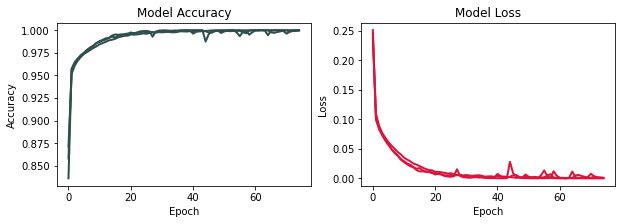

In [11]:
rn_model = resnet_model(X_train.shape[1:], num_models = number_models, dropout_rate = dropout_rate, num_dense_nodes=64)
rn_model.compile(verbose = 1)
rn_model.summary()

epochs=75
if nukeBright==26:
    epochs = 200
rn_model.train_models_with_one_trainset(X_train, y_train,
                                        sample_weights = train_weight,
                                        batch_size = batch_size, 
                                        train_epochs = epochs,
                                        verbose = 1)



fig = pyl.figure(figsize=(10,3))

ax1 = pyl.subplot(121)
for k in range(number_models):
    ax1.plot(rn_model.classifiers[k].history['accuracy'], color='darkslategray', linewidth=2)
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2 = pyl.subplot(122)
for k in range(number_models):
    ax2.plot(rn_model.classifiers[k].history['loss'], color='crimson', linewidth=2)
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

pyl.show()
pyl.close()

# Save the Model

In [12]:
saveModel = True
if saveModel:
    rn_model.saveModel(mean,std,save_dir=f'RNML_KBmod_modelSave_{nukeBright}_{nukeFaint}_wRotAug_7', random_split_seed=410)
    print('saved')


   saved to RNML_KBmod_modelSave_10.0_27.0_wRotAug_7/model_0

   saved to RNML_KBmod_modelSave_10.0_27.0_wRotAug_7/model_1

   saved to RNML_KBmod_modelSave_10.0_27.0_wRotAug_7/model_2

saved


# Validation

Finally, we use the model trained above to make predictions on the test/validation sample. We then compare these predicted labels with the original ones, and derive a prediction accuracy. 

In [13]:
preds_test = rn_model.predict(X_test, verbose=1)

preds_train = rn_model.predict(X_train, verbose=1)




103/103 [==============================] - 3s 33ms/step


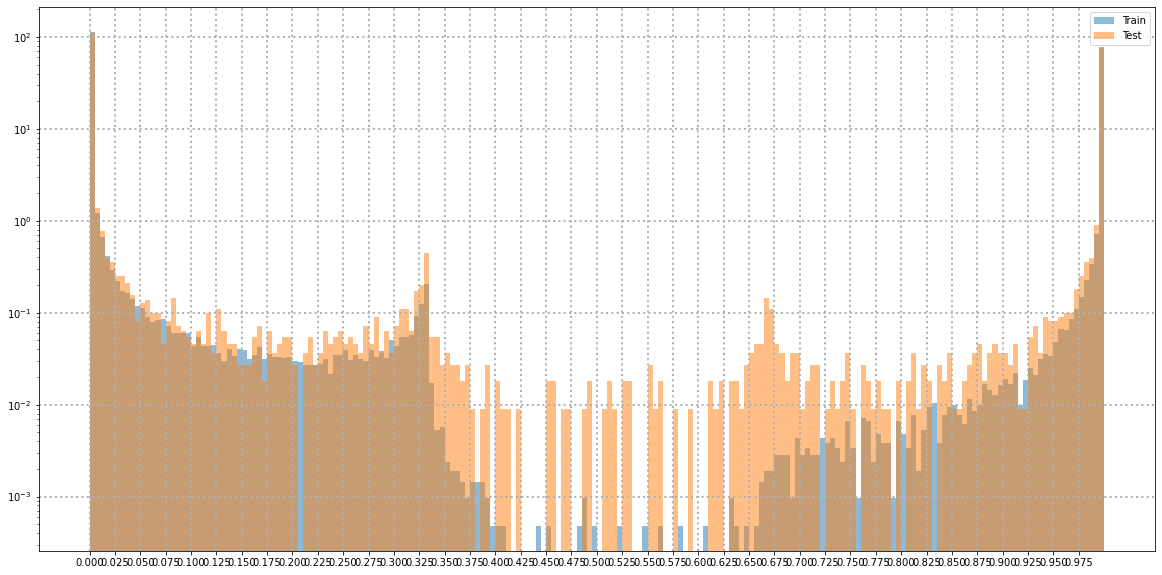

In [14]:

pyl.figure(figsize=(20,10))
pyl.hist(preds_train[:, 1], bins=200, density=True,alpha=0.5, label='Train', log=True)
pyl.hist(preds_test[:, 1], bins=200, density=True,alpha=0.5,label='Test', log=True)
pyl.xticks(np.arange(0., 1., 0.025))
pyl.grid(linestyle=':', lw=2)
pyl.legend()
pyl.show()

20920
19.00 0.9227 1.0000 0.80 4.0
19.25 1.0000 1.0000 1.00 5.0
19.50 1.0000 1.0000 1.00 18.0
19.75 0.9568 1.0000 0.95 18.0
20.00 0.9641 1.0000 0.97 28.0
20.25 0.9942 1.0000 1.00 46.0
20.50 0.6667 1.0000 0.88 43.0
20.75 0.9884 1.0000 0.98 57.0
21.00 0.9985 1.0000 1.00 68.0
21.25 0.9771 1.0000 0.97 71.0
21.50 0.7082 1.0000 0.98 123.0
21.75 0.9896 1.0000 0.99 181.0
22.00 0.9985 1.0000 1.00 177.0
22.25 0.6706 1.0000 0.98 164.0
22.50 0.9890 1.0000 1.00 215.0
22.75 0.6913 1.0000 0.99 211.0
23.00 0.5504 1.0000 0.97 331.0
23.25 0.3488 1.0000 0.96 332.0
23.50 0.6849 1.0000 0.98 328.0
23.75 0.6151 1.0000 0.98 350.0
24.00 0.5500 1.0000 0.97 459.0
24.25 0.2345 1.0000 0.96 471.0
24.50 0.7054 1.0000 0.97 563.0
24.75 0.6492 1.0000 0.97 573.0
25.00 0.4695 1.0000 0.98 608.0
25.25 0.6529 1.0000 0.96 598.0
25.50 0.1329 1.0000 0.96 605.0
25.75 0.3948 1.0000 0.95 614.0
26.00 0.0041 1.0000 0.92 550.0
26.25 0.1860 1.0000 0.89 480.0
26.50 0.0042 1.0000 0.87 312.0
26.75 0.4005 1.0000 0.83 176.0

Number of fal

/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


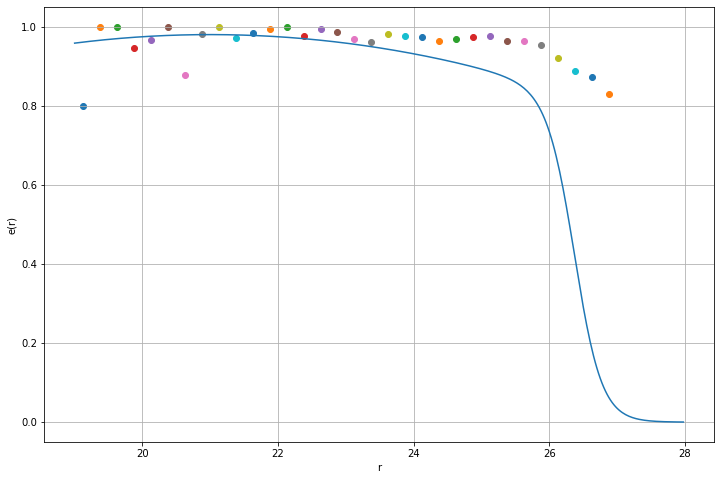

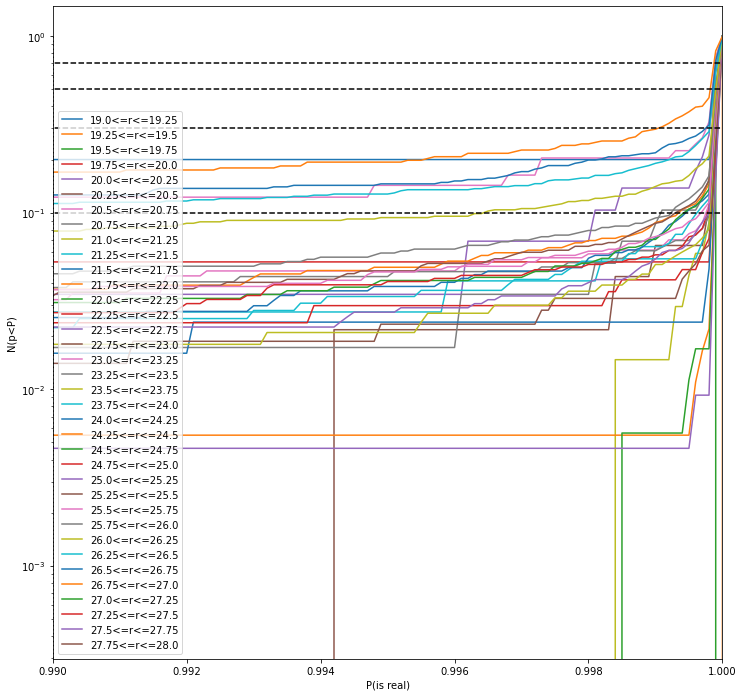

In [15]:

def Eff(m,  eff_max=0.8295, c=0.0054, M_0=26.3803,sig= 0.2016  ):
    return (eff_max-c*(m-21.0)**2)/(1+np.exp((m-M_0)/sig))

# measure the distribution of p values as a function of magnitude
eff_fig = pyl.figure('Efficiency Estimate', figsize=(12, 8))
eff_sp = eff_fig.add_subplot(111)
eff_sp.set_xlabel('r')
eff_sp.set_ylabel('e(r)')
                  
figure = pyl.figure('P-value histogram', figsize=(12, 12))
sp = figure.add_subplot(111)

good_p_value = 0.99
m_step = 0.25

print(len(np.where(preds_test>good_p_value)[0]))

bins = np.linspace(0.0,1.0,10000)
n_false = bins*0.0
n_found = 0.0
K = np.sum(np.less(bins,good_p_value))
n_bin_diff = 0
for m in np.arange(19.,28.,m_step):
    # plot the P-value cumulative distributions
    w = np.where( ((source_details[test_index, 5]-m)>=0) & ((source_details[test_index, 5]-m)<=m_step) )
    p_values = preds_test[w[0],1]
    
    n = bins*0.0
    k = ((p_values-bins[0])/(bins[1]-bins[0])).astype(np.int)
    for i in k:
        n[i:]+=1.0
    n_found+=n[-1]-n[K]
    n/=n[-1]
    
    
    # plot the efficiency curve estimate
    
    sp.plot(bins,n,label=f'{m}<=r<={m+m_step}')
    eff_sp.scatter(m+m_step/2.,1.0-n[K])
    if len(p_values)>0:
        print('{:.2f} {:.4f} {:.4f} {:.2f} {}'.format( m, np.min(p_values), np.max(p_values), 1.0-n[K], n_found-n_bin_diff ))
    n_bin_diff = n_found
    
emags = np.arange(19.,28.,m_step/10.)
eff_sp.plot(emags,Eff(emags, eff_max=0.98))

# now sum up the false positives
w = np.where( (source_details[test_index, 5])==0) 
p_values_false = preds_test[w[0],1]

k = ((p_values_false-bins[0])/(bins[1]-bins[0])).astype(np.int)
for i in k:
    n_false[:i]+=1.0

print()
print(f'Number of false-marked candidates with P>{good_p_value}:',np.sum(n_false[K:]))
print(f'Number of sources marked as real with P>{good_p_value}:',n_found)

n_false/=n_false[0]
pyl.plot(bins, n_false,'k:', lw=4)

eff_sp.grid()
    
pyl.plot([0, 1], [0.1, 0.1], 'k--')
pyl.plot([0, 1], [0.3, 0.3], 'k--')
pyl.plot([0, 1], [0.5, 0.5], 'k--')
pyl.plot([0, 1], [0.7, 0.7], 'k--')
pyl.plot([good_p_value, good_p_value], [0, 1], 'k:')
sp.legend()
sp.set_yscale('log')
sp.set_xlim(0.99,1.0)
pyl.xlabel('P(is real)')
pyl.ylabel('N(p<P)')
pyl.show()

In [16]:
#running model 0
#model 0 10% P~0.96, 2% P~0.975. Both come up with nearly identical found planted ~2900
#model 1 10% P~0.92, 2% P~0.935. Both come up with nearly identical found planted ~2900
#model 2 10% P~0.985, 2% P~0.991. Both come up with nearly identical found planted ~2900
#model 3 10% P~0.91, 2% P~0.935. Both come up with nearly identical found planted ~2900
